In [1]:
import os
import pandas as pd
import datetime
from matplotlib import pyplot
from matplotlib.ticker import FormatStrFormatter
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import auc
from sklearn.utils import class_weight
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import CuDNNLSTM
from keras.layers import CuDNNGRU
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Lambda
from keras.layers import Dropout
from keras.layers import SimpleRNN
from keras.utils import generic_utils
from keras.utils import Sequence
from keras import regularizers
from keras import optimizers
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import numpy as np
import scipy 
import math
import h5py
import time
import copy
import sys
import feather
from sklearn.metrics import mean_absolute_error
from numpy.random import seed
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
seed(123)
from tensorflow import set_random_seed
set_random_seed(456)
np.set_printoptions(threshold=sys.maxsize)

Using TensorFlow backend.


In [2]:
import keras
print(os.getcwd())
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.keras.backend.set_session(tf.Session(config=config))
from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

/home/whsu014/dev/mlrig/Experiments


## Check CVD deaths

In [3]:
#################################
# check observation window does 
# not peek ahead to CVD death
#################################
#view_1hot_df = feather.read_dataframe("/home/whsu014/data/view_1hot_nona_len29_float_age_impute_and_True_HG_100096inds.feather")
view_1hot_df = feather.read_dataframe("/home/whsu014/data/view_imp_fatal_cvd_patched_100096inds.feather")
print(view_1hot_df.shape)

#test_df = feather.read_dataframe("/home/whsu014/data/Test_set_with_TRUE_10096inds.feather")
test_df = feather.read_dataframe("/home/whsu014/data/test_imp_fatal_cvd_patched_10096inds.feather")
print(test_df.shape)

(2902784, 191)
(282688, 189)


In [4]:
print(view_1hot_df.columns.get_loc('PT_IMP_FATAL_CVD'))
print(test_df.columns.get_loc('PT_IMP_FATAL_CVD'))

print(view_1hot_df.iloc[:, 183].unique())
print(test_df.iloc[:, 181].unique())
cvd_death_test_ids = test_df[test_df.iloc[:, 181]==1].iloc[:, 0].unique()

183
181
[0. 1.]
[0. 1.]


In [5]:
idx = 30
#died_ids = test_df[test_df.iloc[:, 181]==1].iloc[:, 0].unique()
#died_inds = test_df[test_df.iloc[:, 0].isin(died_ids)]
cvd_death_train_ids = view_1hot_df[view_1hot_df.iloc[:, 183]==1].iloc[:, 0].unique()
#cvd_death_inds = view_1hot_df[view_1hot_df.iloc[:, 0].isin(cvd_death_train_ids)]
#print(len(cvd_death_train_ids))
#print(cvd_death_inds.shape)
#print(cvd_death_inds.iloc[(idx*29):((idx+1)*29), [0,1,183]])

In [6]:
print(view_1hot_df.columns.get_loc('DIED'))
print(test_df.columns.get_loc('DIED'))
died_train_ids = view_1hot_df[view_1hot_df.iloc[:, 17]==1].iloc[:, 0].unique()
print("DIED in train:", len(died_train_ids))
died_test_ids = test_df[test_df.iloc[:, 16]==1].iloc[:, 0].unique()
print("DIED in test:", len(died_test_ids))
print()
print("CVD deaths (train):", len(cvd_death_train_ids))
print("CVD deaths (test):", len(cvd_death_test_ids))
print()
print("Non-CVD death (train):\t", len(list(i for i in died_train_ids if\
                                           i not in set(cvd_death_train_ids))))
print("Non-CVD death (test):\t", len(list(i for i in died_test_ids if \
                                          i not in set(cvd_death_test_ids))))

17
16
DIED in train: 6634
DIED in test: 694

CVD deaths (train): 2998
CVD deaths (test): 341

Non-CVD death (train):	 3636
Non-CVD death (test):	 353


## Start here 

In [7]:
# set up training set
#view_1hot_df = feather.read_dataframe("/home/whsu014/data/view_1hot_nona_len29_float_age_impute_and_True_HG_100096inds.feather")
view_1hot_df = feather.read_dataframe("/home/whsu014/data/view_imp_fatal_cvd_patched_100096inds.feather")
print(view_1hot_df.columns)
print(view_1hot_df.shape)

print(view_1hot_df['CVD_ISOSORBRIDE_DINITRATE'].unique())
view_1hot_df = view_1hot_df.drop(['CVD_ISOSORBRIDE_DINITRATE'], axis=1)
print(view_1hot_df.shape)
print("Number of inds:", len(view_1hot_df['VSIMPLE_INDEX_MASTER'].unique()))
# set length to 28
print(view_1hot_df.shape[0]/29)
view_1hot_df = copy.deepcopy(view_1hot_df[view_1hot_df['QUARTER']!=0])
print(view_1hot_df.shape[0]/28)
# Take 90000 inds for train and validation set
# remove true values
# remove QUARTER
view_1hot_df = view_1hot_df.drop(['QUARTER'], axis=1)
train_v = copy.deepcopy(view_1hot_df.iloc[:(28*90000), :-7].values)
print(train_v.shape)
print(train_v.shape[0]/28)

# set up test set
#test_df = feather.read_dataframe("/home/whsu014/data/Test_set_with_TRUE_10096inds.feather")
test_df = feather.read_dataframe("/home/whsu014/data/test_imp_fatal_cvd_patched_10096inds.feather")

print(test_df.columns)
print(test_df.shape)
print("Number of inds:", len(test_df['VSIMPLE_INDEX_MASTER'].unique()))
test_v = copy.deepcopy(test_df.iloc[:, :-7].values) # or test_ if removing prediction window before scaling

Index(['VSIMPLE_INDEX_MASTER', 'QUARTER', 'AGE', 'SEX', 'NZDEP', 'ETHN_1',
       'ETHN_2', 'ETHN_3', 'ETHN_4', 'ETHN_5',
       ...
       'PT_DIABETES_YR', 'PT_ATRIAL_FIBRILLATION', 'PT_IMP_FATAL_CVD',
       'TRUE_HDL', 'TRUE_LDL', 'TRUE_TRI', 'TRUE_TCL', 'TRUE_TCHDL',
       'TRUE_HBA1C', 'TRUE_EGFR'],
      dtype='object', length=191)
(2902784, 191)
[0.]
(2902784, 190)
Number of inds: 100096
100096.0
100096.0
(2520000, 182)
90000.0
Index(['VSIMPLE_INDEX_MASTER', 'AGE', 'SEX', 'NZDEP', 'ETHN_1', 'ETHN_2',
       'ETHN_3', 'ETHN_4', 'ETHN_5', 'TEST',
       ...
       'PT_DIABETES_YR', 'PT_ATRIAL_FIBRILLATION', 'PT_IMP_FATAL_CVD',
       'TRUE_HDL', 'TRUE_LDL', 'TRUE_TRI', 'TRUE_TCL', 'TRUE_TCHDL',
       'TRUE_HBA1C', 'TRUE_EGFR'],
      dtype='object', length=189)
(282688, 189)
Number of inds: 10096


In [4]:
# This block removes the prediction window 
# from the train and test set before scaling

print(train_v.shape)
num_of_inds = train_v.shape[0]//28
num_of_features = train_v.shape[1]
print("Number of inds (train) :{}".format(num_of_inds))
print("Number of features (train) :{}".format(num_of_features))

train_ = np.empty((num_of_inds*8, train_v.shape[1]))
for i in range(num_of_inds):
    ind_v = train_v[(i*28):((i+1)*28), :]
    train_[(i*8):((i+1)*8), :] = ind_v[:8, :]
print(train_.shape)
print(train_.shape[0]/8)

print()

print(test_v.shape)
num_of_inds = test_v.shape[0]//28
num_of_features = test_v.shape[1]
print("Number of inds (test): {}".format(num_of_inds))
print("Number of features (test): {}".format(num_of_features))

test_ = np.empty((num_of_inds*8, test_v.shape[1]))
for i in range(num_of_inds):
    ind_v = test_v[(i*28):((i+1)*28), :]
    test_[(i*8):((i+1)*8), :] = ind_v[:8, :]
print(test_.shape)
print(test_.shape[0]/8)

(2520000, 182)
Number of inds (train) :90000
Number of features (train) :182
(720000, 182)
90000.0

(282688, 182)
Number of inds (test): 10096
Number of features (test): 182
(80768, 182)
10096.0


In [5]:
# standardise data
# z = (X - u)/s
# u is the mean of the training samples
# s is the standard devidation of the training samples
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train_) 
scaled_test = scaler.transform(test_)

In [6]:
print("Number of days:", view_1hot_df.columns.get_loc('NUMBER_OF_DAYS'))
print("Acute adm:", view_1hot_df.columns.get_loc('ACUTE_ADM'))
print("Mortality broad cvd with other:", view_1hot_df.columns.get_loc('mortality_broad_cvd_with_other'))
print("out broad_cvd:", view_1hot_df.columns.get_loc('out_broad_cvd'))
print("out atrial fibrillation:", view_1hot_df.columns.get_loc('out_atrial_fibrillation'))
print("PT IMP FATAL CVD:", view_1hot_df.columns.get_loc('PT_IMP_FATAL_CVD'))

Number of days: 120
Acute adm: 121
Mortality broad cvd with other: 143
out broad_cvd: 145
out atrial fibrillation: 162
PT IMP FATAL CVD: 181


In [7]:
print("Number of days:", test_df.columns.get_loc('NUMBER_OF_DAYS'))
print("Acute adm:", test_df.columns.get_loc('ACUTE_ADM'))
print("Mortality broad cvd with other:", test_df.columns.get_loc('mortality_broad_cvd_with_other'))
print("out broad_cvd:", test_df.columns.get_loc('out_broad_cvd'))
print("out atrial fibrillation:", test_df.columns.get_loc('out_atrial_fibrillation'))
print("PT IMP FATAL CVD:", test_df.columns.get_loc('PT_IMP_FATAL_CVD'))

Number of days: 120
Acute adm: 121
Mortality broad cvd with other: 143
out broad_cvd: 145
out atrial fibrillation: 162
PT IMP FATAL CVD: 181


In [8]:
def setup_xy(time_series, scaled_time_series):
    #################################
    # construct y
    #################################
    num_of_inds = time_series.shape[0]//28
    num_of_features = time_series.shape[1]
    print("Number of individuals:", num_of_inds)

    y_ = np.empty((num_of_inds, 2))
    for i in range(num_of_inds):
        ind_v = time_series[(i*28):((i+1)*28), :]
        event = False
        for j in range(8, 28):
            if ind_v[j, 121] == 1.0 and \
                1.0 in ind_v[j, 143:162]:  # it is an acute CVD event (Atrial fibrillation is not a CVD event)
                event = True
        if 1.0 in ind_v[8:, 181]:
            event = True
        if event:
            y_[i, :] = np.array([0.0, 1.0])
        else:
            y_[i, :] = np.array([1.0, 0.0])
    print("Number of individuals who had a CVD event:", \
          sum(y_[:, 1]))
    print("Event ratio:", sum(y_[:, 1])/num_of_inds)
    ##################################
    # construct x
    ##################################
    x_ = np.empty((num_of_inds, 8, num_of_features))
    for i in range(num_of_inds):
        #scaled_ind_v = scaled_time_series[(i*28):((i+1)*28), :]
        scaled_ind_v = scaled_time_series[(i*8):((i+1)*8), :]
        x_[i] = scaled_ind_v[:8, :]
    return x_, y_

In [9]:
x_train, y_train = setup_xy(train_v, scaled_train)
x_test, y_test = setup_xy(test_v, scaled_test) 

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

Number of individuals: 90000
Number of individuals who had a CVD event: 10945.0
Event ratio: 0.12161111111111111
Number of individuals: 10096
Number of individuals who had a CVD event: 1286.0
Event ratio: 0.12737717908082408
(90000, 8, 182)
(90000, 2)
(10096, 8, 182)
(10096, 2)


In [10]:
###########################################
# Number of patients with a CVD event
# (Fatal or non-fatal) in their prediction 
# window 
###########################################
print(y_train[y_train[:, 1]==1].shape)
print(y_test[y_test[:, 1]==1].shape)

(10945, 2)
(1286, 2)


In [9]:
######################################################
# Sample weighting -- 
# Inversely proportional contribution to cost function
# set sample weight
######################################################
'''
unique, counts = np.unique(y_train[:, 1], return_counts=True)
print(dict(zip(unique, counts)))

s_weight = class_weight.compute_sample_weight("balanced",
                                              y_train[:, 1])
print(s_weight.shape)
print(np.unique(s_weight))
print(s_weight[:20, ])
'''

{0.0: 78528, 1.0: 11472}
(90000,)
[0.57304401 3.92259414]
[0.57304401 0.57304401 0.57304401 0.57304401 0.57304401 0.57304401
 0.57304401 3.92259414 0.57304401 0.57304401 0.57304401 0.57304401
 0.57304401 0.57304401 0.57304401 0.57304401 0.57304401 0.57304401
 3.92259414 0.57304401]


9000


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7ff07bf0e710>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 81000 samples, validate on 9000 samples
Epoch 1/200
 - 2s - loss: 1.7444 - acc: 0.4970 - val_loss: 1.6395 - val_acc: 0.5046

Epoch 00001: val_loss improved from inf to 1.63949, saving model to EVENT_val_weights1.hdf5
Epoch 2/200
 - 1s - loss: 1.5708 - acc: 0.5235 - val_loss: 1.4781 - val_acc: 0.5334

Epoch 00002: val_loss improved from 1.63949 to 1.47809, saving model to EVENT_val_weights1.hdf5
Epoch 3/200
 - 1s - loss: 1.4205 - acc: 0.5517 - val_loss: 1.3392 - val_acc: 0.5648

Epoch 00003: val_loss improved from 1.47809 to 1.33921, saving model to EVENT_val_weights1.hdf5
Epoch 4/200
 - 1s - loss: 1.2916 - acc: 0.5793 - val_loss: 1.2205 - val_acc: 0.5930

Epoch 00004: val_loss improved from 1.33921 to 1.22049, saving model to EVENT_val_weights1.hdf5
Epoch 5/200
 - 1s - loss: 1.1813 - acc: 0.6083 - val_loss: 1.1185 - val_acc: 0.6260

Epoch 00005: val_loss improved from 1.22049 to 1.11847, saving model to EVENT_val_weights1.hdf5
Epoch 6/200
 - 1s - loss: 1.0868 - acc: 0.6358 - v

 - 1s - loss: 0.5391 - acc: 0.7523 - val_loss: 0.5374 - val_acc: 0.7511

Epoch 00049: val_loss did not improve from 0.53647
Epoch 50/200
 - 1s - loss: 0.5389 - acc: 0.7540 - val_loss: 0.5375 - val_acc: 0.7500

Epoch 00050: val_loss did not improve from 0.53647
Epoch 51/200
 - 1s - loss: 0.5388 - acc: 0.7526 - val_loss: 0.5374 - val_acc: 0.7502

Epoch 00051: val_loss did not improve from 0.53647
Epoch 52/200
 - 1s - loss: 0.5388 - acc: 0.7534 - val_loss: 0.5366 - val_acc: 0.7500

Epoch 00052: val_loss did not improve from 0.53647
Epoch 53/200
 - 1s - loss: 0.5388 - acc: 0.7525 - val_loss: 0.5369 - val_acc: 0.7500

Epoch 00053: val_loss did not improve from 0.53647
Epoch 54/200
 - 1s - loss: 0.5387 - acc: 0.7530 - val_loss: 0.5375 - val_acc: 0.7493

Epoch 00054: val_loss did not improve from 0.53647
Epoch 55/200
 - 1s - loss: 0.5385 - acc: 0.7522 - val_loss: 0.5370 - val_acc: 0.7493

Epoch 00055: val_loss did not improve from 0.53647
Epoch 56/200
 - 1s - loss: 0.5384 - acc: 0.7530 - val_


Epoch 00106: val_loss did not improve from 0.53443
Epoch 107/200
 - 1s - loss: 0.5359 - acc: 0.7519 - val_loss: 0.5350 - val_acc: 0.7451

Epoch 00107: val_loss did not improve from 0.53443
Epoch 108/200
 - 1s - loss: 0.5358 - acc: 0.7521 - val_loss: 0.5351 - val_acc: 0.7454

Epoch 00108: val_loss did not improve from 0.53443
Epoch 109/200
 - 1s - loss: 0.5358 - acc: 0.7518 - val_loss: 0.5348 - val_acc: 0.7458

Epoch 00109: val_loss did not improve from 0.53443
Epoch 110/200
 - 1s - loss: 0.5357 - acc: 0.7523 - val_loss: 0.5347 - val_acc: 0.7456

Epoch 00110: val_loss did not improve from 0.53443
Epoch 111/200
 - 1s - loss: 0.5357 - acc: 0.7516 - val_loss: 0.5347 - val_acc: 0.7452

Epoch 00111: val_loss did not improve from 0.53443
Epoch 112/200
 - 1s - loss: 0.5357 - acc: 0.7516 - val_loss: 0.5347 - val_acc: 0.7459

Epoch 00112: val_loss did not improve from 0.53443
Epoch 113/200
 - 1s - loss: 0.5357 - acc: 0.7519 - val_loss: 0.5347 - val_acc: 0.7453

Epoch 00113: val_loss did not imp


Epoch 00164: val_loss did not improve from 0.53387
Epoch 165/200
 - 1s - loss: 0.5349 - acc: 0.7505 - val_loss: 0.5347 - val_acc: 0.7459

Epoch 00165: val_loss did not improve from 0.53387
Epoch 166/200
 - 1s - loss: 0.5349 - acc: 0.7506 - val_loss: 0.5355 - val_acc: 0.7454

Epoch 00166: val_loss did not improve from 0.53387
Epoch 167/200
 - 1s - loss: 0.5348 - acc: 0.7505 - val_loss: 0.5359 - val_acc: 0.7471

Epoch 00167: val_loss did not improve from 0.53387
Epoch 168/200
 - 1s - loss: 0.5349 - acc: 0.7504 - val_loss: 0.5352 - val_acc: 0.7454

Epoch 00168: val_loss did not improve from 0.53387
Epoch 169/200
 - 1s - loss: 0.5349 - acc: 0.7502 - val_loss: 0.5346 - val_acc: 0.7466

Epoch 00169: val_loss did not improve from 0.53387
Epoch 170/200
 - 1s - loss: 0.5349 - acc: 0.7504 - val_loss: 0.5352 - val_acc: 0.7451

Epoch 00170: val_loss did not improve from 0.53387
Epoch 171/200
 - 1s - loss: 0.5348 - acc: 0.7498 - val_loss: 0.5348 - val_acc: 0.7459

Epoch 00171: val_loss did not imp

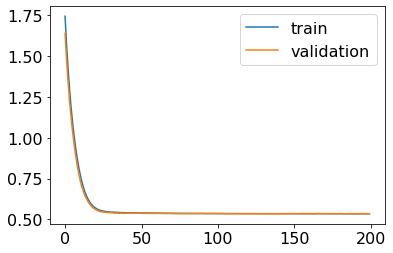

(10096, 2)


In [64]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)

num_per_fold = x_train.shape[0]//10
print(num_per_fold)
#####################################
#LSTM
#units = 16
#batch_s = 16384
#L2_1 = 0.05441600579314996
#After imp_fatal_cvd patch
#units = 32
#batch_s = 16384
#L2_1 = 0.0642170047601527
#Search with Sample weight
#units = 16
#batch_s = 16384
#L2_1 = 0.6691108365625354
#####################################
#L2_2 = 2.092561938722815e-05
#lr = 0.04113387739738984
#decay = 1.566949434233884e-06
#####################################
# Simple RNN 
#units = 8 #2
#batch_s = 8192 #256
#L2_1 = 0.10788586002261571
# after imp_fatal_cvd patch
units = 4
batch_s = 8192
L2_1 = 0.13182753578641435
######################################

for f in range(1):#10
    #start = f*num_per_fold
    end = (f+1)*num_per_fold
    train1_x = x_train[:end, ]
    train2_x = x_train[end:, ]
    train_x_lstm = np.append(train2_x, train1_x, axis=0) 
    train1_y = y_train[:end, ]
    train2_y = y_train[end:, ]
    train_y_lstm = np.append(train2_y, train1_y, axis=0)
    
    start_time_inner = time.time()
    #config = tf.ConfigProto(log_device_placement = True)
    #config.gpu_options.visible_device_list='1'
    with tf.Session(config = tf.ConfigProto(log_device_placement = True)):
        model = Sequential()
        model.add(SimpleRNN(units,
                            kernel_regularizer=regularizers.l2(L2_1),
                            #return_sequences=True, 
                            input_shape=(8, 182))) #20 , 27
        #model.add(CuDNNLSTM(units, 
        #                   kernel_regularizer=regularizers.l2(L2_2)))
                            #return_sequences=True))
        model.add(Dense(2, activation='softmax'))
        #adam = optimizers.Adam(lr=0.0015) #decay=1e-4
        #sgdm = optimizers.SGD(lr=lr, momentum=0.9, decay=decay) 
        model.compile(loss='categorical_crossentropy',
                      optimizer='adam', 
                      #weighted_metrics=['loss'],
                      metrics=['accuracy'])
        val_weight = "EVENT_val_weights" + str(f+1) + ".hdf5"
        val_checkpointer = ModelCheckpoint(filepath=val_weight,
                                            monitor='val_loss', verbose=1,
                                            save_best_only=True)
        history = model.fit(train_x_lstm, train_y_lstm, batch_size=batch_s, 
                            epochs=200, validation_split=0.1, 
                            callbacks=[val_checkpointer], 
                            verbose=2, 
                            shuffle=False,
                            #class_weight = {0:0.1, 1:0.9}
                            sample_weight=class_weight.\
                                          compute_sample_weight("balanced",
                                                               train_y_lstm[:, 1])
                           ) 
        print("#################################")
        print("Number of units:", units)
        print("Batch size:", batch_s)
        #print("Learning rate:", lr)
        #print("Decay:", decay)
        print("Fold:", f)
        print("best val loss:", min(history.history['val_loss']))
        print("#################################")
        pyplot.plot(history.history['loss'], label='train')
        pyplot.plot(history.history['val_loss'], label='validation')
        pyplot.legend()
        pyplot.show()
        model.load_weights(val_weight)
        yhat_test = model.predict(x_test)
print(yhat_test.shape)

In [65]:
print(yhat_test.shape)
yhat_test_df = pd.DataFrame(yhat_test)
y_test_df = pd.DataFrame(y_test)
yhat_test_df.columns = ['NO_EVENT', 'EVENT']
y_test_df.columns = ['NO_EVENT', 'EVENT']
feather.write_dataframe(yhat_test_df, "/home/whsu014/data/EVENT_RNN_L201_Sample_Weight_IFC_patched_Hparam_searched_yhat.feather")
#feather.write_dataframe(y_test_df, "/home/whsu014/data/EVENT_IFC_patched_y.feather")

(10096, 2)


## Models comparison

In [8]:
#lstm_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LSTM_class_weight_yhat.feather")
#lstm_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LSTM_sample_weight_yhat.feather")
#lstm_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LSTM_2Layers_yhat.feather")
#lstm_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LSTM_L201_yhat.feather")
###lstm_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LSTM_L201_Sample_Weight_yhat.feather") Thesis results
#lstm_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LSTM_L201_Sample_Weight_yhat_testI.feather")# repeat above 
#lstm_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LSTM_L201_Sample_Weight_yhat_test.feather")# remove x from test before scaling test
#IFC - imp_fatal_cvd
#lstm_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LSTM_L201_No_Weighting_100epoch_IFC_patched_yhat.feather")
#lstm_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LSTM_L201_Sample_Weight_100epoch_IFC_patched_yhat.feather")
#lstm_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LSTM_L201_No_Weighting_IFC_patched_old_hparams_yhat.feather")# 200 epochs
#lstm_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LSTM_L201_Sample_Weight_IFC_patched_old_hparams_yhat.feather") # 200 epochs
lstm_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LSTM_L201_No_Weighting_IFC_patched_yhat.feather") # H-params searched with no weight
#lstm_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LSTM_L201_Sample_Weight_IFC_patched_yhat.feather") # H-params searched with no weight
#lstm_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LSTM_L2_1_No_Weighting_IFC_patched_Hyperparameter_searched_w_Sample_Weight_yhat.feather") # H-params searched with weight
#lstm_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LSTM_L2_1_Sample_Weight_IFC_patched_Hyperparameter_searched_w_Sample_Weight_yhat.feather") # H-params searched with weight

#lstm_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LSTM_L201_SGDM_yhat.feather")
#lstm_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LSTM_L201_SetupXThenScale_yhat.feather")#no sample weight
#lstm_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LSTM_L201_SetupXThenScale_Sample_Weight_yhat.feather")
#lstm_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LSTM_L201_SetupXThenScale_Sample_Weight_HParams_yhat.feather")

#rnn_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_RNN_yhat.feather")
#rnn_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_RNN_Sample_Weight_yhat.feather")
#rnn_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_RNN_L201_yhat.feather")
###rnn_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_RNN_L201_Sample_Weight_yhat.feather")
#rnn_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_RNN_L201_Sample_Weight_yhat_test.feather")# remove x from test before scaling test
#IFC - imp_fatal_cvd
#rnn_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_RNN_L201_No_Weighting_IFC_patched_yhat.feather") # Old params
#rnn_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_RNN_L201_Sample_Weight_IFC_patched_yhat.feather") # Old params
#rnn_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_RNN_L201_No_Weighting_IFC_patched_Hparam_searched_yhat.feather") # H-params searched without weight
rnn_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_RNN_L201_Sample_Weight_IFC_patched_Hparam_searched_yhat.feather") # H-params searched without weight

#mlp_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_MLP_yhat.feather")
#mlp_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_MLP_Sample_Weight_yhat.feather")
#mlp_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_MLP_SetupXThenScale_Sample_Weight_yhat.feather")
#mlp_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_MLP_SetupXThenScale_Sample_Weight_HParams_yhat.feather")
#IFC - imp_fatal_cvd
mlp_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_MLP_No_Weighting_IFC_patched_yhat.feather")
#mlp_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_MLP_Sample_Weight_IFC_patched_yhat.feather")

#rc_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_RC_yhat.feather")
#####rc_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_RC_normalized_yhat.feather")
#rc_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_RC_normalized_Class_Weight_yhat.feather")
#rc_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_RC_yhat_test.feather")
# imp_fatal_cvd patch
rc_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_RC_IFC_patched_yhat.feather")
#rc_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_RC_Class_Weight_IFC_patched_yhat.feather")

######rc_a_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_RC_aggregated_yhat.feather")
#rc_a_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_RC_aggregated_normalized_yhat.feather")
#rc_a_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_RC_aggregated_normalized_Class_Weight_yhat.feather")
# imp_fatal_cvd patch
rc_a_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_RC_A_IFC_patched_yhat.feather")
#rc_a_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_RC_A_Class_Weight_IFC_patched_yhat.feather")

######rc_l_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_RC_last_quarter_yhat.feather") #this is normalised
#rc_l_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_RC_last_quarter_normalized_Class_Weight_yhat.feather")
# imp_fatal_cvd patch
rc_l_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_RC_L_IFC_patched_yhat.feather")
#rc_l_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_RC_L_Class_Weight_IFC_patched_yhat.feather")

#lr_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LR_yhat.feather")
######lr_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LR_normalized_yhat.feather")
#lr_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LR_normalized_yhat_10000iter.feather")
#lr_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LR_normalized_Class_Weight_yhat.feather")
#lr_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LR_normalized_Class_weight_yhat_10000iter.feather")
# imp_fatal_cvd patch
lr_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LR_IFC_patched_yhat.feather")
#lr_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LR_Class_Weight_IFC_patched_yhat.feather")

#lr_a_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LR_aggregated_yhat.feather")
#lr_a_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LR_aggregated_normalized_yhat.feather")
#lr_a_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LR_aggregated_normalized_yhat_1000iter.feather")
#lr_a_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LR_aggregated_normalized_Class_Weight_yhat.feather")
######lr_a_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LR_aggregated_normalized_Class_weight_yhat_test.feather")
#lr_a_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LR_aggregated_normalized_Class_weight_yhat_1000iter.feather")
# imp_fatal_cvd patch
#lr_a_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LR_A_IFC_patched_yhat.feather")
lr_a_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LR_A_Class_Weight_IFC_patched_yhat.feather")
                                      
#lr_l_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LR_last_quarter_yhat.feather")
#####lr_l_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LR_last_quarter_normalized_yhat.feather")
#lr_l_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LR_last_quarter_normalized_yhat_10000iter.feather")
#lr_l_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LR_last_quarter_normalized_Class_Weight_yhat.feather")
#lr_l_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LR_last_quarter_normalized_Class_weight_yhat_10000iter.feather")
# imp_fatal_cvd patch
lr_l_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LR_L_IFC_patched_yhat.feather")
#lr_l_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LR_L_Class_Weight_IFC_patched_yhat.feather")

#####cox_a_yhat_df = feather.read_dataframe("/home/whsu014/data/Cox_EVENT_aggregated_yhat_10096inds.feather")
#cox_a_yhat_df = feather.read_dataframe("/home/whsu014/data/Cox_EVENT_aggregated_normalized_yhat.feather")
# imp_fatal_cvd
cox_a_yhat_df = feather.read_dataframe("/home/whsu014/data/Cox_EVENT_aggregated_IFC_patched_yhat.feather")

#cox_l_yhat_df = feather.read_dataframe("/home/whsu014/data/Cox_EVENT_last_quarter_yhat_10096inds.feather")
#cox_l_yhat_df = feather.read_dataframe("/home/whsu014/data/Cox_EVENT_last_quarter_normalized_yhat.feather")

#####cox_l_yhat_df = feather.read_dataframe("/home/whsu014/data/Cox_EVENT_last_quarter_yhat_test.feather")
# imp_fatal_cvd
cox_l_yhat_df = feather.read_dataframe("/home/whsu014/data/Cox_EVENT_last_quarter_IFC_patched_yhat.feather")

#####################################
# Multi_PDC_EVENT
#####################################
#lstm_yhat_df = feather.read_dataframe("/home/whsu014/data/Multi_EVENT_LSTM_Sample_Weight_yhat.feather")
multi_lstm_yhat_df = feather.read_dataframe("/home/whsu014/data/Multi_EVENT_LSTM_IFC_Patched_yhat.feather")
#lstm_yhat_df = feather.read_dataframe("/home/whsu014/data/Multi_EVENT_LSTM_IFC_Patched_Sample_Weight_yhat.feather")

#####################################
# balanced data
# linear model experiment
#####################################
'''
rc_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_balanced_RC_yhat.feather")
rc_a_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_balanced_RC_aggregated_yhat.feather")
rc_l_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_balanced_RC_last_quarter_yhat.feather")
lr_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_balanced_LR_yhat.feather")
lr_a_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_balanced_LR_aggregated_yhat.feather")
lr_l_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_balanced_LR_last_quarter_yhat.feather")
cox_a_yhat_df = feather.read_dataframe("/home/whsu014/data/Cox_EVENT_balanced_aggregated_yhat.feather")
cox_l_yhat_df = feather.read_dataframe("/home/whsu014/data/Cox_EVENT_balanced_last_quarter_yhat.feather")
y_df = feather.read_dataframe("/home/whsu014/data/EVENT_balanced_y_test.feather")
y_df = pd.concat([y_df, y_df], axis=1)
print(y_df.shape)
'''
##########################################################

#y_df = feather.read_dataframe("/home/whsu014/data/EVENT_y.feather")
y_df = feather.read_dataframe("/home/whsu014/data/EVENT_IFC_patched_y.feather")
#y_df.columns = ['NO EVENT', 'EVENT']
#feather.write_dataframe("/home/whsu014/data/EVENT_y.feather")
#y_mlp_df = feather.read_dataframe("/home/whsu014/data/PDC_y_MLP.feather")

multi_lstm_yhat = multi_lstm_yhat_df.values

lstm_yhat = lstm_yhat_df.values
rnn_yhat = rnn_yhat_df.values
mlp_yhat = mlp_yhat_df.values

rc_yhat = rc_yhat_df.values
rc_a_yhat = rc_a_yhat_df.values
rc_l_yhat = rc_l_yhat_df.values
lr_yhat = lr_yhat_df.values
lr_a_yhat = lr_a_yhat_df.values
lr_l_yhat = lr_l_yhat_df.values
cox_a_yhat = cox_a_yhat_df.values
cox_l_yhat = cox_l_yhat_df.values

y = y_df.values

LSTM:			ROC AUC = 0.798
RNN:			ROC AUC = 0.795
MLP:			ROC AUC = 0.797
RC:			ROC AUC = 0.799
RC (aggregated):	ROC AUC = 0.800
RC (last quarter):	ROC AUC = 0.794
LR:			ROC AUC = 0.798
LR (aggregated):	ROC AUC = 0.802
LR (last quarter):	ROC AUC = 0.797
Cox (aggregated):	ROC AUC = 0.798
Cox (last quarter):	ROC AUC = 0.793


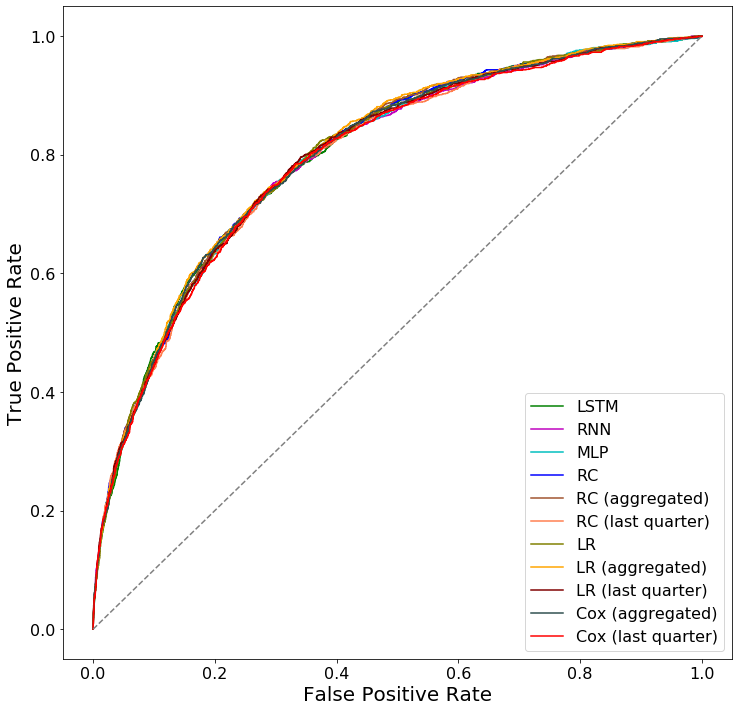

In [11]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fs = 20

lstm_auc = roc_auc_score(y[:, 1], 
                         lstm_yhat[:, 1])
rnn_auc = roc_auc_score(y[:, 1],
                         rnn_yhat[:, 1])
mlp_auc = roc_auc_score(y[:, 1],
                         mlp_yhat[:, 1])

rc_auc = roc_auc_score(y[:, 1], 
                          rc_yhat[:, 0])
rc_a_auc = roc_auc_score(y[:, 1], 
                          rc_a_yhat[:, 0])
rc_l_auc = roc_auc_score(y[:, 1],
                         rc_l_yhat[:, 0])
lr_auc = roc_auc_score(y[:, 1],
                         lr_yhat[:, 0])
lr_a_auc = roc_auc_score(y[:, 1],
                         lr_a_yhat[:, 0])
lr_l_auc = roc_auc_score(y[:, 1],
                         lr_l_yhat[:, 0])
cox_a_auc = roc_auc_score(y[:, 1],
                         cox_a_yhat[:, 0])
cox_l_auc = roc_auc_score(y[:, 1],
                         cox_l_yhat[:, 0])

print('LSTM:\t\t\tROC AUC = %.3f' % (lstm_auc))
print('RNN:\t\t\tROC AUC = %.3f' %(rnn_auc))
print('MLP:\t\t\tROC AUC = %.3f' %(mlp_auc))
print('RC:\t\t\tROC AUC = %.3f' %(rc_auc))
print('RC (aggregated):\tROC AUC = %.3f' %(rc_a_auc))
print('RC (last quarter):\tROC AUC = %.3f' %(rc_l_auc))
print('LR:\t\t\tROC AUC = %.3f' %(lr_auc))
print('LR (aggregated):\tROC AUC = %.3f' %(lr_a_auc))
print('LR (last quarter):\tROC AUC = %.3f' %(lr_l_auc))
print('Cox (aggregated):\tROC AUC = %.3f' %(cox_a_auc))
print('Cox (last quarter):\tROC AUC = %.3f' %(cox_l_auc))

lstm_fp, lstm_tp, _ = roc_curve(y[:, 1], 
                                lstm_yhat[:, 1])
rnn_fp, rnn_tp, _ = roc_curve(y[:, 1], 
                              rnn_yhat[:, 1])
mlp_fp, mlp_tp, _ = roc_curve(y[:, 1], 
                              mlp_yhat[:, 1])

rc_fp, rc_tp, _ = roc_curve(y[:, 1], 
                            rc_yhat[:, 0])
rc_a_fp, rc_a_tp, _ = roc_curve(y[:, 1], 
                            rc_a_yhat[:, 0])
rc_l_fp, rc_l_tp, _ = roc_curve(y[:, 1], 
                            rc_l_yhat[:, 0])
lr_fp, lr_tp, _ = roc_curve(y[:, 1],
                            lr_yhat[:, 0])
lr_a_fp, lr_a_tp, _ = roc_curve(y[:, 1],
                            lr_a_yhat[:, 0])
lr_l_fp, lr_l_tp, _ = roc_curve(y[:, 1], 
                            lr_l_yhat[:, 0])
cox_a_fp, cox_a_tp, _ = roc_curve(y[:, 1],
                                 cox_a_yhat[:, 0])
cox_l_fp, cox_l_tp, _ = roc_curve(y[:, 1],
                                 cox_l_yhat[:, 0])

pyplot.rcParams.update({'font.size':16})
pyplot.figure(figsize=(12,12))

pyplot.plot(lstm_fp, lstm_tp, color='g', 
            linestyle='-', label='LSTM')
pyplot.plot(rnn_fp, rnn_tp, color='m', 
            linestyle='-', label='RNN')    
pyplot.plot(mlp_fp, mlp_tp, color='c', 
             linestyle='-', label='MLP')
pyplot.plot(rc_fp, rc_tp, color='b', 
             linestyle='-', label='RC')
pyplot.plot(rc_a_fp, rc_a_tp, color='sienna', 
             linestyle='-', label='RC (aggregated)')
pyplot.plot(rc_l_fp, rc_l_tp, color='coral', 
             linestyle='-', label='RC (last quarter)')

pyplot.plot(lr_fp, lr_tp, color='olive', 
             linestyle='-', label='LR')
pyplot.plot(lr_a_fp, lr_a_tp, color='orange', 
             linestyle='-', label='LR (aggregated)')
pyplot.plot(lr_l_fp, lr_l_tp, color='maroon', 
             linestyle='-', label='LR (last quarter)')
pyplot.plot(cox_a_fp, cox_a_tp, color='darkslategray', 
             linestyle='-', label='Cox (aggregated)')
pyplot.plot(cox_l_fp, cox_l_tp, color='red', 
             linestyle='-', label='Cox (last quarter)')#'lightseagreen'


pyplot.plot([0, 1], [0, 1], color='grey', linestyle='--')
#pyplot.title('ROC curves CVD event prediction', fontsize=fs*1.1)
pyplot.xlabel('False Positive Rate', fontsize=fs)
pyplot.ylabel('True Positive Rate', fontsize=fs)
pyplot.legend(fontsize=fs*0.8, loc='lower right')
filename = "/home/whsu014/plots/EVENT_ROC_Curves_IFC_patched.png"
#pyplot.savefig(filename)
pyplot.show()

LSTM			Average precision-recall score: 0.411
RNN			Average precision-recall score: 0.418
MLP			Average precision-recall score: 0.415
RC			Average precision-recall score: 0.420
RC (aggregated)		Average precision-recall score: 0.421
RC (last quarter)	Average precision-recall score: 0.417
LR 			Average precision-recall score: 0.411
LR (aggregated)		Average precision-recall score: 0.421
LR (last quarter)	Average precision-recall score: 0.414
Cox (aggregated)	Average precision-recall score: 0.417
Cox (last quarter)	Average precision-recall score: 0.411

LSTM			Precision-recall AUC : 0.411
RNN			Precision-recall AUC : 0.418
MLP			Precision-recall AUC : 0.414
RC			Precision-recall AUC : 0.420
RC (aggregated):	Precision-recall AUC : 0.421
RC (last quarter):	Precision-recall AUC : 0.416
LR 			Precision-recall AUC : 0.411
LR (aggregated):	Precision-recall AUC : 0.420
LR (last quarter):	Precision-recall AUC : 0.413
Cox (aggregated):	Precision-recall AUC : 0.417
Cox (last quarter):	Precision-recal

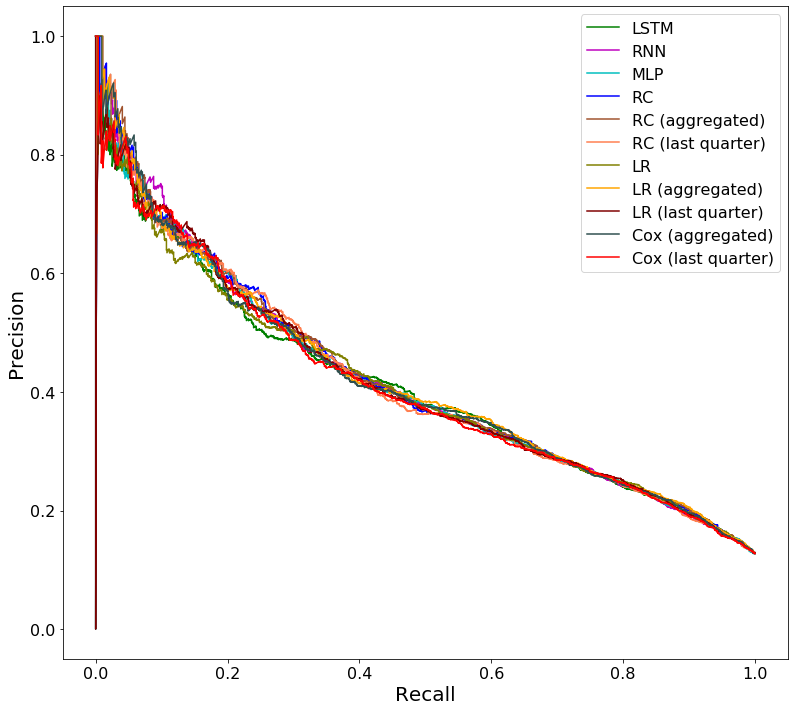

In [12]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import auc

fs = 20

lstm_p, lstm_r, _ = precision_recall_curve(y[:, 1], 
                                lstm_yhat[:, 1])
rnn_p, rnn_r, _ = precision_recall_curve(y[:, 1], 
                              rnn_yhat[:, 1])
mlp_p, mlp_r, _ = precision_recall_curve(y[:, 1], 
                              mlp_yhat[:, 1])

rc_p, rc_r, _ = precision_recall_curve(y[:, 1], 
                            rc_yhat[:, 0])
rc_a_p, rc_a_r, _ = precision_recall_curve(y[:, 1], 
                            rc_a_yhat[:, 0])
rc_l_p, rc_l_r, _ = precision_recall_curve(y[:, 1], 
                            rc_l_yhat[:, 0])
lr_p, lr_r, _ = precision_recall_curve(y[:, 1], 
                            lr_yhat[:, 0])
lr_a_p, lr_a_r, _ = precision_recall_curve(y[:, 1], 
                            lr_a_yhat[:, 0])
lr_l_p, lr_l_r, _ = precision_recall_curve(y[:, 1], 
                            lr_l_yhat[:, 0])
cox_a_p, cox_a_r, _ = precision_recall_curve(y[:, 1], 
                            cox_a_yhat[:, 0])
cox_l_p, cox_l_r, _ = precision_recall_curve(y[:, 1], 
                            cox_l_yhat[:, 0])

average_lstm_p = average_precision_score(y[:, 1], 
                                         lstm_yhat[:, 1])
average_rnn_p = average_precision_score(y[:, 1], 
                                         rnn_yhat[:, 1])
average_mlp_p = average_precision_score(y[:, 1], 
                                         mlp_yhat[:, 1])

average_rc_p = average_precision_score(y[:, 1], 
                                         rc_yhat[:, 0])
average_rc_a_p = average_precision_score(y[:, 1], 
                                         rc_a_yhat[:, 0])
average_rc_l_p = average_precision_score(y[:, 1], 
                                         rc_l_yhat[:, 0])
average_lr_p = average_precision_score(y[:, 1], 
                                         lr_yhat[:, 0])
average_lr_a_p = average_precision_score(y[:, 1], 
                                         lr_a_yhat[:, 0])
average_lr_l_p = average_precision_score(y[:, 1], 
                                         lr_l_yhat[:, 0])
average_cox_a_p = average_precision_score(y[:, 1], 
                                         cox_a_yhat[:, 0])
average_cox_l_p = average_precision_score(y[:, 1], 
                                         cox_l_yhat[:, 0])

print('LSTM\t\t\tAverage precision-recall score: {0:0.3f}'.format(
      average_lstm_p))
print('RNN\t\t\tAverage precision-recall score: {0:0.3f}'.format(
      average_rnn_p))
print('MLP\t\t\tAverage precision-recall score: {0:0.3f}'.format(
      average_mlp_p))

print('RC\t\t\tAverage precision-recall score: {0:0.3f}'.format(
      average_rc_p))
print('RC (aggregated)\t\tAverage precision-recall score: {0:0.3f}'.format(
      average_rc_a_p))
print('RC (last quarter)\tAverage precision-recall score: {0:0.3f}'.format(
      average_rc_l_p))
print('LR \t\t\tAverage precision-recall score: {0:0.3f}'.format(
      average_lr_p))
print('LR (aggregated)\t\tAverage precision-recall score: {0:0.3f}'.format(
      average_lr_a_p))
print('LR (last quarter)\tAverage precision-recall score: {0:0.3f}'.format(
      average_lr_l_p))
print('Cox (aggregated)\tAverage precision-recall score: {0:0.3f}'.format(
      average_cox_a_p))
print('Cox (last quarter)\tAverage precision-recall score: {0:0.3f}'.format(
      average_cox_l_p))
print()

lstm_pr_auc = auc(lstm_r, lstm_p)
rnn_pr_auc = auc(rnn_r, rnn_p)
mlp_pr_auc = auc(mlp_r, mlp_p)

rc_pr_auc = auc(rc_r, rc_p)
rc_a_pr_auc = auc(rc_a_r, rc_a_p) #added a
rc_l_pr_auc = auc(rc_l_r, rc_l_p)
lr_pr_auc = auc(lr_r, lr_p)
lr_a_pr_auc = auc(lr_a_r, lr_a_p)
lr_l_pr_auc = auc(lr_l_r, lr_l_p)
cox_a_pr_auc = auc(cox_a_r, cox_a_p)
cox_l_pr_auc = auc(cox_l_r, cox_l_p)

print('LSTM\t\t\tPrecision-recall AUC : %.3f' % (lstm_pr_auc))
print('RNN\t\t\tPrecision-recall AUC : %.3f' %(rnn_pr_auc))
print('MLP\t\t\tPrecision-recall AUC : %.3f' %(mlp_pr_auc))

print('RC\t\t\tPrecision-recall AUC : %.3f' %(rc_pr_auc))
print('RC (aggregated):\tPrecision-recall AUC : %.3f' %(rc_a_pr_auc))
print('RC (last quarter):\tPrecision-recall AUC : %.3f' %(rc_l_pr_auc))
print('LR \t\t\tPrecision-recall AUC : %.3f' %(lr_pr_auc))
print('LR (aggregated):\tPrecision-recall AUC : %.3f' %(lr_a_pr_auc))
print('LR (last quarter):\tPrecision-recall AUC : %.3f' %(lr_l_pr_auc))
print('Cox (aggregated):\tPrecision-recall AUC : %.3f' %(cox_a_pr_auc))
print('Cox (last quarter):\tPrecision-recall AUC : %.3f' %(cox_l_pr_auc))

pyplot.rcParams.update({'font.size':16})
pyplot.figure(figsize=(13,12))

pyplot.plot(lstm_r, lstm_p, color='g', 
            linestyle='-', label='LSTM')
pyplot.plot(rnn_r, rnn_p, color='m', 
            linestyle='-', label='RNN')
pyplot.plot(mlp_r, mlp_p, color='c', 
             linestyle='-', label='MLP')

pyplot.plot(rc_r, rc_p, color='b', 
             linestyle='-', label='RC')
pyplot.plot(rc_a_r, rc_a_p, color='sienna', 
             linestyle='-', label='RC (aggregated)')
pyplot.plot(rc_l_r, rc_l_p, color='coral', 
             linestyle='-', label='RC (last quarter)')
pyplot.plot(lr_r, lr_p, color='olive', 
             linestyle='-', label='LR')
pyplot.plot(lr_a_r, lr_a_p, color='orange', 
             linestyle='-', label='LR (aggregated)')
pyplot.plot(lr_l_r, lr_l_p, color='maroon', 
             linestyle='-', label='LR (last quarter)')
pyplot.plot(cox_a_r, cox_a_p, color='darkslategray', 
             linestyle='-', label='Cox (aggregated)')
pyplot.plot(cox_l_r, cox_l_p, color='red', 
             linestyle='-', label='Cox (last quarter)')#'lightseagreen'

#pyplot.plot([0, 1], color='grey', linestyle='--')
#pyplot.title('Precision-recall curves CVD event prediction', fontsize=fs*1.1)
pyplot.xlabel('Recall', fontsize=fs)
pyplot.ylabel('Precision', fontsize=fs)
pyplot.legend(fontsize=fs*0.8)
filename = "/home/whsu014/plots/EVENT_PR_Curves_IFC_patched.png"
#pyplot.savefig(filename)
pyplot.show()

## subplot

/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


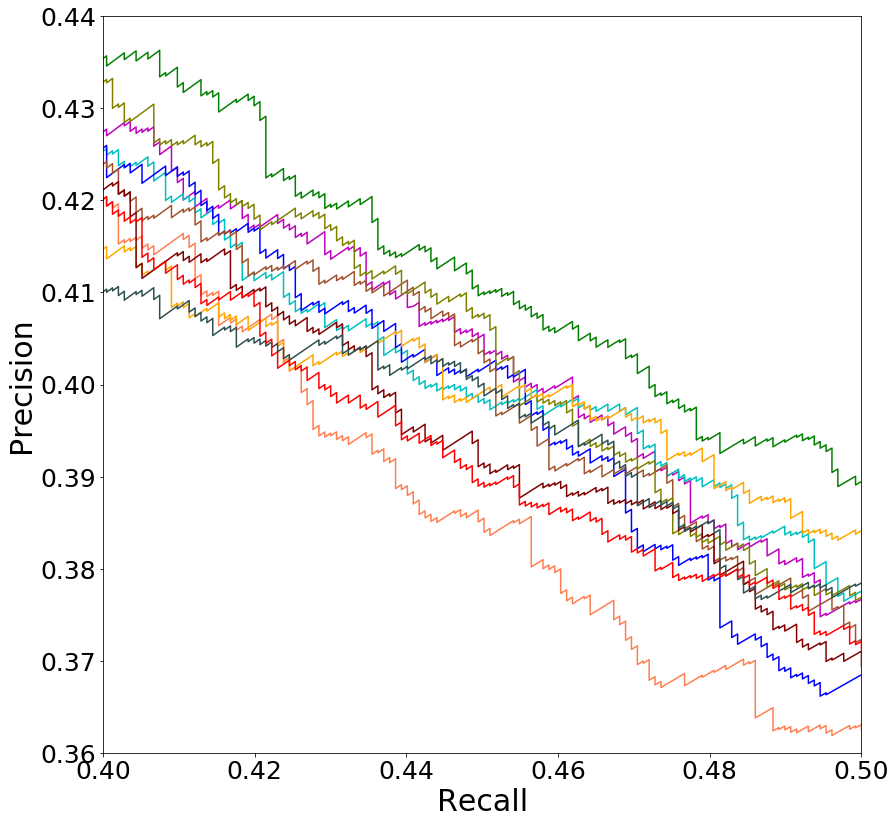

In [7]:
fs = 25
pyplot.rcParams.update({'font.size':25})
pyplot.figure(figsize=(13,12))
pyplot.margins(0)

ax1 = pyplot.subplot(111)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

#ax1.set_xlim(left = 0.7, right= 0.8)
#ax1.set_ylim(bottom = 0.24, top = 0.30)

#ax1.set_xlim(left = 0.8, right= 0.9)
#ax1.set_ylim(bottom = 0.185, top = 0.255)

#ax1.set_xlim(left = 0.9, right= 1)
#ax1.set_ylim(bottom = 0.12, top = 0.21)

#ax1.set_xlim(left = 0.1, right= 0.2)
#ax1.set_ylim(bottom = 0.54, top = 0.76)

#ax1.set_xlim(left = 0.2, right= 0.3)
#ax1.set_ylim(bottom = 0.48, top = 0.61)

#ax1.set_xlim(left = 0.3, right= 0.4)
#ax1.set_ylim(bottom = 0.40, top = 0.52)

#ax1.set_xlim(left = 0.6, right= 0.7)
#ax1.set_ylim(bottom = 0.28, top = 0.355)

#ax1.set_xlim(left = 0.5, right= 0.6)
#ax1.set_ylim(bottom = 0.325, top = 0.395)

ax1.set_xlim(left = 0.4, right= 0.5)
ax1.set_ylim(bottom = 0.36, top = 0.44)

#ax1.set_xlim(left = 0.0, right= 0.1)
#ax1.set_ylim(bottom = 0.6, top = 1)


ax1.plot(lstm_r, lstm_p, color='g', 
            linestyle='-', label='LSTM')

ax1.plot(rnn_r, rnn_p, color='m', 
            linestyle='-', label='RNN')
ax1.plot(mlp_r, mlp_p, color='c', 
             linestyle='-', label='MLP')

ax1.plot(rc_r, rc_p, color='b', 
             linestyle='-', label='RC')
ax1.plot(rc_a_r, rc_a_p, color='sienna', 
             linestyle='-', label='RC (aggregated)')
ax1.plot(rc_l_r, rc_l_p, color='coral', 
             linestyle='-', label='RC (last quarter)')
ax1.plot(lr_r, lr_p, color='olive', 
             linestyle='-', label='LR')
ax1.plot(lr_a_r, lr_a_p, color='orange', 
             linestyle='-', label='LR (aggregated)')
ax1.plot(lr_l_r, lr_l_p, color='maroon', 
             linestyle='-', label='LR (last quarter)')
ax1.plot(cox_a_r, cox_a_p, color='darkslategray', 
             linestyle='-', label='Cox (aggregated)')
ax1.plot(cox_l_r, cox_l_p, color='red', 
             linestyle='-', label='Cox (last quarter)') #'lightseagreen'
             
#pyplot.plot([0, 1], color='grey', linestyle='--')
#yplot.title('Precision-recall curves CVD event prediction \n detail (recall in the range [0.9, 1.0])', fontsize=fs*1.1)
pyplot.xlabel('Recall', fontsize=fs*1.2)
pyplot.ylabel('Precision', fontsize=fs*1.2)
#pyplot.legend(fontsize=fs*1.5)
pyplot.tight_layout()
filename = "/home/whsu014/plots/EVENT_PR_Curves_IFC_patched_detail_04_no_title_no_legend.png"
pyplot.savefig(filename)
pyplot.show()

In [4]:
print(len(_))
print(len(lstm_p))
print(len(lstm_r))

10095
10095
10095


## Model Calibration

In [15]:
print(lstm_yhat.shape)
print(rc_yhat.shape)
print(lr_yhat.shape)
print(cox_a_yhat.shape)

print("LSTM min:\t", np.round(min(lstm_yhat[:, 1]), decimals=5))
print("LSTM max:\t", np.round(max(lstm_yhat[:, 1]), decimals=5))

print("RNN min:\t", np.round(min(rnn_yhat[:, 1]), decimals=5))
print("RNN max:\t", np.round(max(rnn_yhat[:, 1]), decimals=5))

print("MLP min:\t", np.round(min(mlp_yhat[:, 1]), decimals=5))
print("MLP max:\t", np.round(max(mlp_yhat[:, 1]), decimals=5))

print("RC min:\t\t", np.round(min(rc_yhat[:, 0]), decimals=5))
print("RC max:\t\t", np.round(max(rc_yhat[:, 0]), decimals=5))
print("LR min:\t\t", np.round(min(lr_yhat[:, 0]), decimals=5))
print("LR max:\t\t", np.round(max(lr_yhat[:, 0]), decimals=5))
print("Cox min:\t", np.round(min(cox_a_yhat[:, 0]), decimals=5))
print("Cox max:\t", np.round(max(cox_l_yhat[:, 0]), decimals=5))

(10096, 2)
(10096, 1)
(10096, 1)
(10096, 1)
LSTM min:	 0.00636
LSTM max:	 0.97283
RNN min:	 0.04689
RNN max:	 0.9757
MLP min:	 2e-05
MLP max:	 1.0
RC min:		 -1.24828
RC max:		 1.16478
LR min:		 -4.8969
LR max:		 4.5465
Cox min:	 0.0
Cox max:	 0.99607


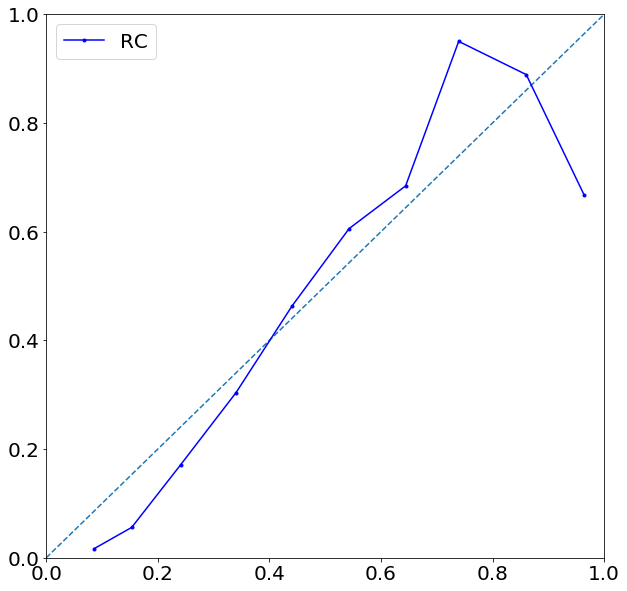

In [37]:
fs = 25
pyplot.rcParams.update({'font.size':20})
pyplot.figure(figsize=(10, 10))
pyplot.margins(0)

prob_true, prob_pred = calibration_curve(y[:, 1], 
                                         #lstm_yhat[:, 1], 
                                         rc_yhat[:],
                                         normalize=True,
                                         n_bins = 10)
pyplot.plot([0, 1], [0, 1], linestyle='--')
pyplot.plot(prob_pred, prob_true, marker='.', color='b', label='RC')
pyplot.legend()
pyplot.show()

In [49]:
##########################################
# Implement own calibration function
##########################################
def calibration(y_yhat, bins):
    step = 1.0/bins
    mean_pred_prob = []
    n_list = []
    p_list = []
    proportion_positive = []
    for i in range(bins):
        temp_v = y_yhat[y_yhat[:, 1] > i*step]
        temp_v = temp_v[temp_v[:, 1] <= (i+1)*step]
        if len(temp_v) != 0 :
            mean_pred_prob.append(np.mean(temp_v[:, 1]))
            print("Mean pred prob:", np.mean(temp_v[:, 1]))
            positive_samples_in_bin = temp_v[temp_v[:, 0] == 1]
            n_list.append(temp_v.shape[0])
            p_list.append(positive_samples_in_bin.shape[0])
            print("Number in bin:", temp_v.shape[0])
            print("Positive sample in bin:", positive_samples_in_bin.shape[0])
            proportion_positive.append(positive_samples_in_bin.shape[0]/temp_v.shape[0])
            print("Proportion of positive samples:",
              positive_samples_in_bin.shape[0]/temp_v.shape[0])
    return mean_pred_prob, proportion_positive, n_list, p_list

In [50]:
print(rc_yhat.shape)
print(min(rc_yhat))
print(max(rc_yhat))
#####################################
# normalise decision function
#####################################
yhat = rc_yhat

yhat = (yhat[:, 0] - min(yhat[:, 0]))/(max(yhat[:, 0] - min(yhat[:, 0])))

print(yhat.shape)
print(min(yhat))
print(max(yhat))

(10096, 1)
[0.]
[1.]
(10096,)
0.0
1.0


In [51]:
print(y.shape)
print(yhat.shape)
# NN models
#y_yhat = np.append(np.array([y[:, 1]]).T, 
#                            np.array([lstm_yhat[:, 0]]).T,
#                            axis=1)
# Linear models
y_yhat = np.append(np.array([y[:, 1]]).T, 
                            np.array([yhat]).T,
                            axis=1)
# cox models
#y_yhat = np.append(np.array([y[:, 1]]).T,
#                            np.array([cox_a_yhat[:, 0]]).T,
#                            axis=1)
print(y_yhat.shape)

m_pred_prob, prop_pos, n_list, p_list = calibration(y_yhat, 10)
print(sum(n_list))
print(sum(p_list))

(10096, 2)
(10096,)
(10096, 2)
Mean pred prob: 0.08595901833120437
Number in bin: 418
Positive sample in bin: 7
Proportion of positive samples: 0.01674641148325359
Mean pred prob: 0.15323656189600376
Number in bin: 5633
Positive sample in bin: 315
Proportion of positive samples: 0.05592046866678502
Mean pred prob: 0.24098452488786962
Number in bin: 2523
Positive sample in bin: 432
Proportion of positive samples: 0.17122473246135553
Mean pred prob: 0.3403618944038716
Number in bin: 934
Positive sample in bin: 284
Proportion of positive samples: 0.30406852248394006
Mean pred prob: 0.44071944669733976
Number in bin: 356
Positive sample in bin: 165
Proportion of positive samples: 0.46348314606741575
Mean pred prob: 0.5428814940004316
Number in bin: 142
Positive sample in bin: 86
Proportion of positive samples: 0.6056338028169014
Mean pred prob: 0.644149082833266
Number in bin: 57
Positive sample in bin: 39
Proportion of positive samples: 0.6842105263157895
Mean pred prob: 0.739219615917722

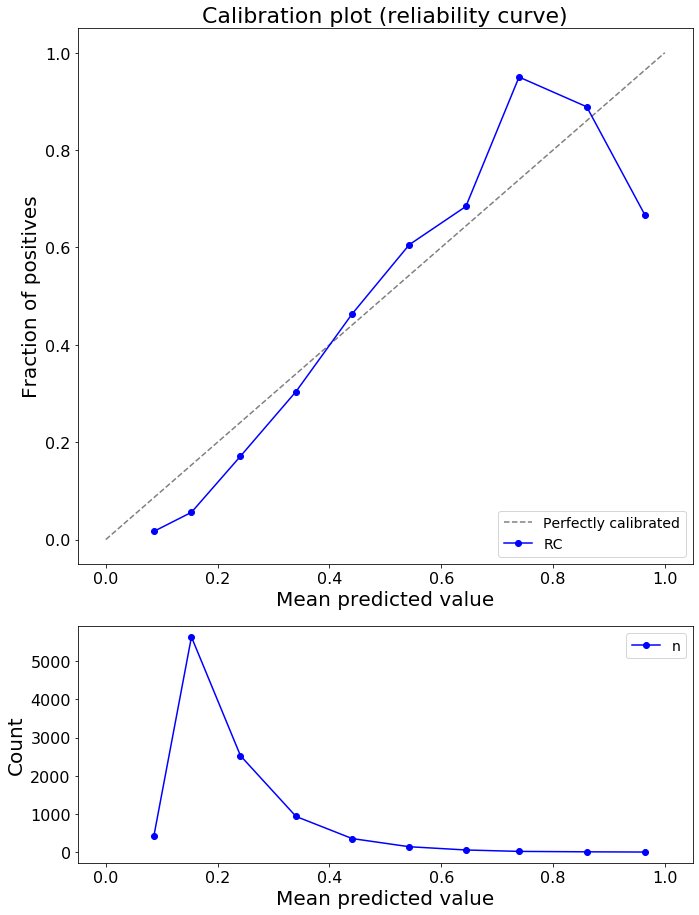

In [52]:
'''
---data---
lstm_yhat    color='g'
rnn_yhat     color='m'
mlp_yhat     color='c'
rc_yhat      color='b'
rc_a_yhat    color='sienna'
rc_l_yhat    color='coral'
lr_yhat      color='olive'
lr_a_yhat    color='orange'
lr_l_yhat    color='maroon'
cox_a_yhat   color='darkslategray'
cox_l_yhat   color='lightseagreen'
y 
'''
pyplot.rcParams.update({'font.size':16})
fs = 20
print()
pyplot.figure(figsize=(10, 13))
ax1 = pyplot.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = pyplot.subplot2grid((3, 1), (2, 0))
color = 'b' 
ax1.set_title('Calibration plot (reliability curve)', fontsize=fs*1.1)
ax1.set_xlabel('Mean predicted value', fontsize=fs)
ax1.set_ylabel('Fraction of positives', fontsize=fs)
ax1.set_xlim([-0.05, 1.05])
ax1.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
ax1.plot(m_pred_prob, prop_pos, marker='o',color=color, label='RC')
ax1.legend(loc='lower right',  fontsize=fs*0.7)
#ax1.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., fontsize=fs*0.8)
color1 = 'b' 
ax2.set_xlabel('Mean predicted value', fontsize=fs)
ax2.set_ylabel('Count', fontsize=fs)
ax2.set_xlim([-0.05, 1.05])
ax2.plot(m_pred_prob, n_list, marker='o', color=color1, label="n")
ax2.legend(loc='upper right', fontsize=fs*0.7)
#ax2.plot(m_pred_prob, p_list, marker='o', color=color2, label="Positive samples")
#ax2.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., fontsize=fs*0.8)
filename = "/home/whsu014/plots/Calibration_balanced_Cox_aggregated.png"
#pyplot.savefig(filename)
pyplot.tight_layout()
pyplot.show()

## Subgroup analysis

In [9]:
print(test_df.shape)
print(test_v.shape)
print(test_df.shape[0]/28)
print(lstm_yhat_df.shape)
print(y_df.shape)

(282688, 189)
(282688, 182)
10096.0
(10096, 2)
(10096, 2)


In [10]:
list(test_df.columns)
print(test_v.shape[0]/28)
num_of_inds = test_v.shape[0]//28
print(num_of_inds)

covariates_list = []
for i in range(num_of_inds):
    ind_v = test_v[(i*28):((i+1)*28), :9]
    covariates_list.append(ind_v[7, :])
covariates_v = np.array(covariates_list)
print(covariates_v.shape)
covariates_df = pd.DataFrame(covariates_v)
covariates_df.columns = list(test_df.columns)[:9]
covariates_df.head()

10096.0
10096
(10096, 9)


,VSIMPLE_INDEX_MASTER,AGE,SEX,NZDEP,ETHN_1,ETHN_2,ETHN_3,ETHN_4,ETHN_5
0,75768.0,52.25,0.0,3.0,1.0,0.0,0.0,0.0,0.0
1,786.0,61.25,1.0,2.0,0.0,1.0,0.0,0.0,0.0
2,46831.0,51.75,1.0,1.0,0.0,0.0,0.0,0.0,1.0
3,11007.0,68.25,1.0,5.0,1.0,0.0,0.0,0.0,0.0
4,41081.0,52.00,0.0,5.0,0.0,1.0,0.0,0.0,0.0


In [11]:
####################################
# Need to normalise RC and LR
# decision function so it can be 
# interpreted as prediction probability
# see: https://scikit-learn.org/stable/auto_examples/calibration/plot_compare_calibration.html#sphx-glr-auto-examples-calibration-plot-compare-calibration-py
####################################

rc_yhat_df.iloc[:, 0] = (rc_yhat_df.iloc[:, 0] - min(rc_yhat_df.iloc[:, 0]))/\
                        (max(rc_yhat_df.iloc[:, 0]) - min(rc_yhat_df.iloc[:, 0]))
rc_a_yhat_df.iloc[:, 0] = (rc_a_yhat_df.iloc[:, 0] - min(rc_a_yhat_df.iloc[:, 0]))/\
                          (max(rc_a_yhat_df.iloc[:, 0]) - min(rc_a_yhat_df.iloc[:, 0]))
rc_l_yhat_df.iloc[:, 0] = (rc_l_yhat_df.iloc[:, 0] - min(rc_l_yhat_df.iloc[:, 0]))/\
                          (max(rc_l_yhat_df.iloc[:, 0]) - min(rc_l_yhat_df.iloc[:, 0]))
lr_yhat_df.iloc[:, 0] = (lr_yhat_df.iloc[:, 0] - min(lr_yhat_df.iloc[:, 0]))/\
                        (max(lr_yhat_df.iloc[:, 0]) - min(lr_yhat_df.iloc[:, 0]))
lr_a_yhat_df.iloc[:, 0] = (lr_a_yhat_df.iloc[:, 0] - min(lr_a_yhat_df.iloc[:, 0]))/\
                          (max(lr_a_yhat_df.iloc[:, 0]) - min(lr_a_yhat_df.iloc[:, 0]))
lr_l_yhat_df.iloc[:, 0] = (lr_l_yhat_df.iloc[:, 0] - min(lr_l_yhat_df.iloc[:, 0]))/\
                          (max(lr_l_yhat_df.iloc[:, 0]) - min(lr_l_yhat_df.iloc[:, 0]))

col_names = list(covariates_df.columns)
analysis_df = pd.concat([covariates_df, 
                             y_df.iloc[:, 1], 
                             lstm_yhat_df.iloc[:, 1],
                             rnn_yhat_df.iloc[:, 1],
                             mlp_yhat_df.iloc[:, 1],
                             rc_yhat_df.iloc[:, 0],
                             rc_a_yhat_df.iloc[:, 0],
                             rc_l_yhat_df.iloc[:, 0],
                             lr_yhat_df.iloc[:, 0],
                             lr_a_yhat_df.iloc[:, 0],
                             lr_l_yhat_df.iloc[:, 0],
                             cox_a_yhat_df.iloc[:, 0],
                             cox_l_yhat_df.iloc[:, 0]],
                             axis=1)
print(analysis_df.shape)
col_names.extend(['Y', 'LSTM', 'RNN', 'MLP', 'RC',
                  'RC_A', 'RC_L', 'LR', 'LR_A', 'LR_L',
                  'COX_A', 'COX_L'])
analysis_df.columns = col_names
#analysis_df.head(20)

(10096, 21)


In [30]:
analysis_df.describe()

,VSIMPLE_INDEX_MASTER,AGE,SEX,NZDEP,ETHN_1,ETHN_2,ETHN_3,ETHN_4,ETHN_5,Y,LSTM,RNN,MLP,RC,RC_A,RC_L,LR,LR_A,LR_L,COX_A,COX_L
count,10096.000000,10096.000000,10096.000000,10096.000000,10096.000000,10096.000000,10096.000000,10096.000000,10096.000000,10096.000000,10096.000000,10096.000000,10096.000000,10096.000000,10096.000000,10096.000000,10096.000000,10096.000000,10096.000000,10096.000000,10096.000000
mean,49572.049822,61.991457,0.434529,3.061609,0.574089,0.101327,0.146989,0.088946,0.088649,0.134410,0.403666,0.405542,0.400470,0.210097,0.177078,0.218517,0.278128,0.258550,0.315851,0.128372,0.128736
std,28838.217611,11.388801,0.495720,1.473681,0.494505,0.301777,0.354112,0.284680,0.284250,0.341109,0.235858,0.237013,0.219213,0.102819,0.088062,0.111302,0.110038,0.095931,0.115184,0.127813,0.130737
min,0.000000,21.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006359,0.046894,0.000023,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24404.250000,54.250000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200603,0.195144,0.212197,0.143614,0.121078,0.147111,0.200603,0.191959,0.235764,0.054238,0.053514
50%,49806.500000,62.250000,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.358261,0.369375,0.361724,0.181925,0.153384,0.186626,0.258722,0.242361,0.294424,0.084704,0.081651
75%,74314.500000,70.000000,1.000000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.584216,0.581033,0.565593,0.246157,0.207408,0.257584,0.337210,0.308297,0.377763,0.150758,0.149191
max,100093.000000,95.500000,1.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.972829,0.975701,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.996069


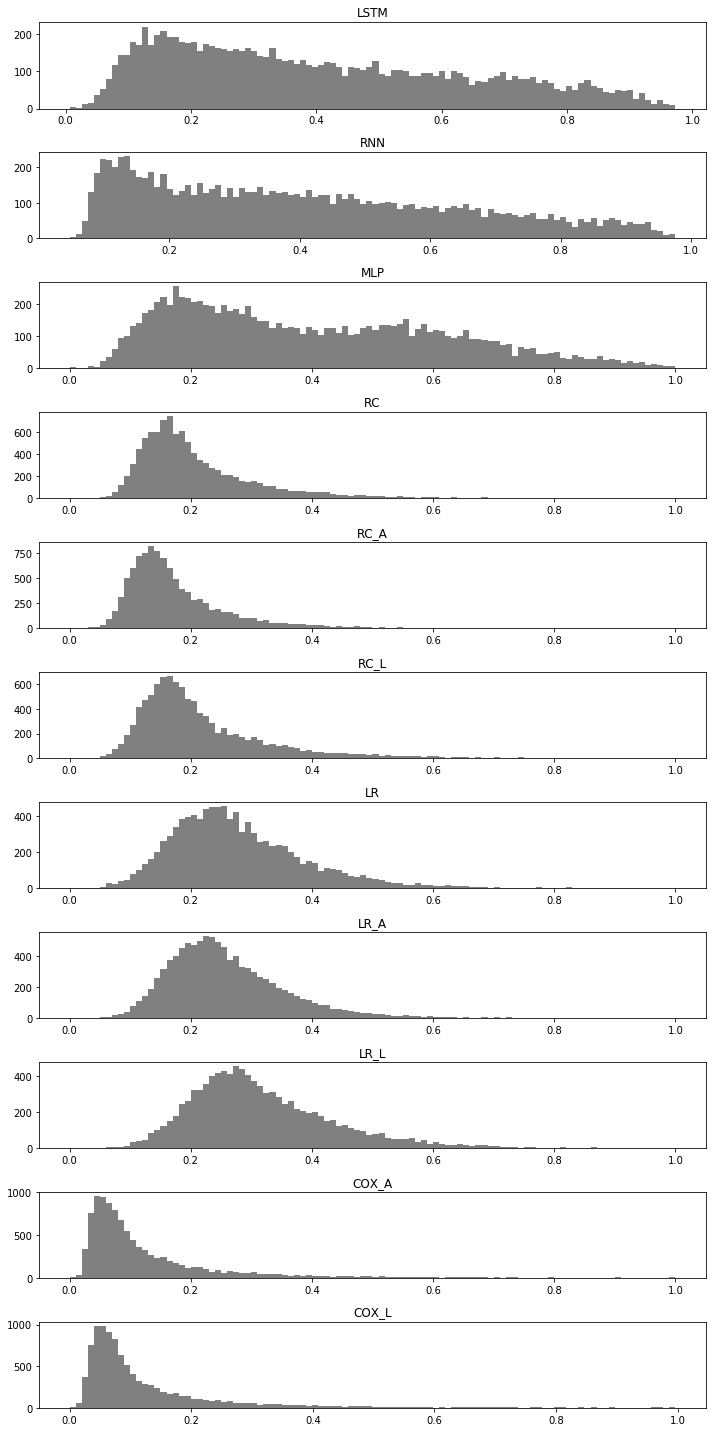

In [16]:
fig, axs = pyplot.subplots(11, 1, figsize=(10, 20))
pyplot.subplots_adjust(hspace=0.5)

model_names = ['LSTM', 'RNN', 'MLP', 'RC', 'RC_A', 
               'RC_L', 'LR', 'LR_A', 'LR_L', 'COX_A',
               'COX_L']

for i in range(11):
    axs[i].hist(analysis_df[model_names[i]], bins=100,
                color='gray')
    axs[i].title.set_text(model_names[i])

filename = "/home/whsu014/plots/CVD_Event_probability_estimates_distribution.png"
pyplot.tight_layout()
pyplot.savefig(filename)
pyplot.show()

In [77]:
#############################
# Get subgroup statistics
# ROC AUC, Average Precision
#############################
sub_analysis_df = analysis_df
sub_df = sub_analysis_df[sub_analysis_df['ETHN_5'] == 1]

idx = 20
print(sub_df.shape)
roc_score = roc_auc_score(sub_df.iloc[:, 9], 
                          sub_df.iloc[:, idx])
print("ROC AUC:\t\t %.3f" %(roc_score))
average_precision = average_precision_score(sub_df.iloc[:, 9], 
                                            sub_df.iloc[:, idx])

print("Average precision:\t %.3f" %(average_precision))
#_p, _r, _ = precision_recall_curve(sub_df.iloc[:, 9], 
#                                   sub_df.iloc[:, 19])

#pr_auc = auc(_r, _p)
#print("Precision-recall AUC:\t\t\t %.3f" %(pr_auc))


(895, 21)
ROC AUC:		 0.829
Average precision:	 0.472


## Bootstrapping 100* 10,000 samples

In [24]:
print(y.shape)
print(lstm_yhat.shape)
print(rc_a_yhat.shape)
print(type(rc_a_yhat))
n_samples = y.shape[0]
y_lstm_multi_lstm_a = np.concatenate((y[:, 1].reshape(n_samples, 1), 
                              lstm_yhat[:, 1].reshape(n_samples, 1), 
                              multi_lstm_yhat[:, 1].reshape(n_samples, 1)), axis=1)
                              #rc_a_yhat[:, 0].reshape(n_samples, 1)), axis=1)
print(y_lstm_multi_lstm_a.shape)
print(y_lstm_multi_lstm_a[:10, :])

(10096, 2)
(10096, 2)
(10096, 1)
<class 'numpy.ndarray'>
(10096, 3)
[[1.         0.05541828 0.05482791]
 [0.         0.05691591 0.05881047]
 [1.         0.00698946 0.00681967]
 [1.         0.42725596 0.39773095]
 [0.         0.05511744 0.06730242]
 [0.         0.01423017 0.01894018]
 [0.         0.19448419 0.19314374]
 [0.         0.0434949  0.06177821]
 [0.         0.04876975 0.04367576]
 [0.         0.21061519 0.16582111]]


In [25]:
from numpy.random import seed
seed(1)

n_samples = y_lstm_multi_lstm_a.shape[0]
print("Number of samples:", n_samples)
n_samples_per_fold = 10000
bstrap_v = np.zeros(((100 * n_samples_per_fold), 3))

print(np.unique(bstrap_v[:, 0]))

idx_list = []

for i in range(100):
    for j in range(n_samples_per_fold):
        idx = np.random.randint(0, n_samples)
        idx_list.append(idx)
        bstrap_v[((i*n_samples_per_fold)+j), :] = y_lstm_multi_lstm_a[idx, :]    
print(np.unique(bstrap_v[:, 0]))
print(bstrap_v.shape)
print(bstrap_v[:10, :])

Number of samples: 10096
[0.]
[0. 1.]
(1000000, 3)
[[1.         0.02921815 0.06296464]
 [0.         0.04841793 0.04110905]
 [0.         0.43308759 0.45803812]
 [0.         0.12499193 0.12644497]
 [1.         0.07847001 0.09144896]
 [1.         0.32612121 0.31741753]
 [0.         0.21673135 0.2413016 ]
 [0.         0.02510667 0.03403603]
 [0.         0.20807555 0.21017654]
 [1.         0.1448608  0.12304138]]


Number per fold: 10000
[[0.42296157 0.42275498]
 [0.44853638 0.44197628]
 [0.43040476 0.43028578]
 [0.39583544 0.38902749]
 [0.43222439 0.42829489]
 [0.41448408 0.40838793]
 [0.43891143 0.44311877]
 [0.43428462 0.43363657]
 [0.42239351 0.41710266]
 [0.42753666 0.43118836]
 [0.42605631 0.42592116]
 [0.43862722 0.43830169]
 [0.45211172 0.45140973]
 [0.43756947 0.4339089 ]
 [0.42444404 0.422984  ]
 [0.41682466 0.41521834]
 [0.44915293 0.44400894]
 [0.43577459 0.43081072]
 [0.42264542 0.42505162]
 [0.43763244 0.43528452]
 [0.45328668 0.4510323 ]
 [0.4257869  0.42578119]
 [0.4334885  0.4334348 ]
 [0.42524176 0.42391457]
 [0.42753182 0.42289673]
 [0.4233325  0.42318587]
 [0.42877014 0.43057109]
 [0.45172005 0.45189116]
 [0.43826991 0.43460601]
 [0.41077437 0.40312321]
 [0.40832484 0.40806124]
 [0.44738773 0.44267922]
 [0.44671045 0.45016369]
 [0.41690658 0.41834381]
 [0.4466776  0.44602135]
 [0.43974448 0.44556195]
 [0.42300812 0.42582786]
 [0.40397621 0.39964538]
 [0.43392436 0.43366784]
 [

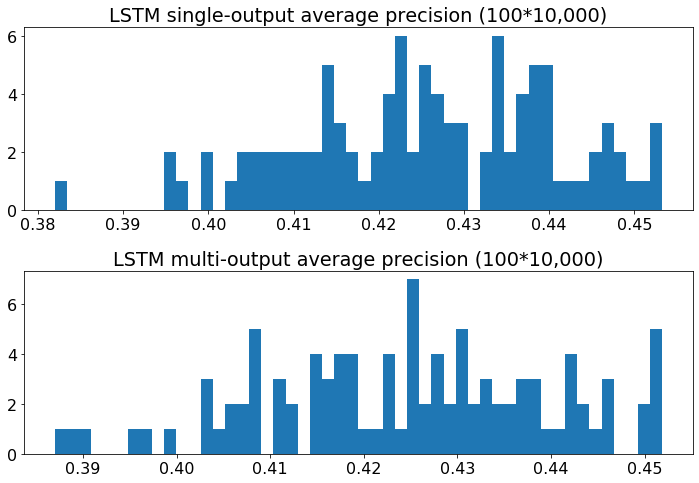

In [26]:
from sklearn.metrics import average_precision_score
from scipy.stats import wilcoxon
from scipy.stats import ttest_ind

n_per_fold = bstrap_v.shape[0]//100
print("Number per fold:", n_per_fold) # 504 use 10080 samples

ap_scores = np.empty((100, 2))

for i in range(100):
    # NN models
    ap_scores[i, 0] = average_precision_score(bstrap_v[(i*n_per_fold):
                                             ((i+1)*n_per_fold), 0], 
                                             bstrap_v[(i*n_per_fold):
                                             ((i+1)*n_per_fold), 1])
    ap_scores[i, 1] = average_precision_score(bstrap_v[(i*n_per_fold):
                                             ((i+1)*n_per_fold), 0],
                                              bstrap_v[(i*n_per_fold):
                                             ((i+1)*n_per_fold), 2])
print(ap_scores)
fig, axs = pyplot.subplots(2,1, figsize=(10, 7))
axs[0].hist(ap_scores[:, 0], bins=50)
axs[0].set_title("LSTM single-output average precision (100*10,000)")
axs[1].hist(ap_scores[:, 1], bins=50)
axs[1].set_title("LSTM multi-output average precision (100*10,000)")
fig.tight_layout()
pyplot.show()

In [27]:
ap_scores_df = pd.DataFrame(ap_scores)
ap_scores_df.columns = ['LSTM_SINGLE_EVENT', 'LSTM_MULTI_EVENT']
feather.write_dataframe(ap_scores_df, "/home/whsu014/data/LSTM_IFC_Patched_single_multi_ap_scores.feather")

## Check data symmetry (mean and median close together)

In [28]:
print(np.mean(ap_scores[:, 0]))
print(np.median(ap_scores[:, 0]))

print(np.mean(ap_scores[:, 1]))
print(np.median(ap_scores[:, 1]))

0.4220175994574992
0.42243120777524734
0.4150718702049742
0.4148238905899073


## Prepare for autorank test
## bootstrap 100 * 10,000

In [82]:
print(y.shape)
print(lstm_yhat.shape)
print(rc_a_yhat.shape)
print(type(rc_a_yhat))
n_samples = y.shape[0]
y_yhats_v = np.concatenate((y[:, 1].reshape(n_samples, 1), 
                          lstm_yhat[:, 1].reshape(n_samples, 1), 
                          rnn_yhat[:, 1].reshape(n_samples, 1),
                          mlp_yhat[:, 1].reshape(n_samples, 1),
                          rc_yhat[:, 0].reshape(n_samples, 1),
                          rc_a_yhat[:, 0].reshape(n_samples, 1),
                          rc_l_yhat[:, 0].reshape(n_samples, 1),
                          lr_yhat[:, 0].reshape(n_samples, 1),
                          lr_a_yhat[:, 0].reshape(n_samples, 1),
                          lr_l_yhat[:, 0].reshape(n_samples, 1), 
                          cox_a_yhat[:, 0].reshape(n_samples, 1),
                          cox_l_yhat[:, 0].reshape(n_samples, 1)), axis=1)
print(y_yhats_v.shape)
print(np.round(y_yhats_v[-10:, :], decimals=3))

(10096, 2)
(10096, 2)
(10096, 1)
<class 'numpy.ndarray'>
(10096, 12)
[[ 0.     0.063  0.366  0.053 -0.87  -0.887 -0.857 -2.877 -0.9   -2.669
   0.062  0.067]
 [ 0.     0.094  0.41   0.089 -0.8   -0.746 -0.801 -2.686 -0.378 -2.471
   0.085  0.077]
 [ 0.     0.189  0.645  0.159 -0.645 -0.648 -0.622 -1.553  0.467 -1.359
   0.188  0.19 ]
 [ 0.     0.073  0.426  0.093 -0.764 -0.765 -0.757 -2.176 -0.263 -2.165
   0.1    0.101]
 [ 0.     0.288  0.735  0.267 -0.477 -0.43  -0.504 -0.799  1.559 -1.021
   0.285  0.262]
 [ 0.     0.121  0.487  0.171 -0.729 -0.726 -0.772 -1.86   0.046 -2.238
   0.119  0.094]
 [ 0.     0.023  0.168  0.017 -0.984 -0.979 -0.977 -3.451 -1.518 -3.389
   0.039  0.038]
 [ 0.     0.039  0.253  0.043 -0.883 -0.886 -0.873 -2.694 -0.971 -2.807
   0.055  0.059]
 [ 0.     0.109  0.455  0.067 -0.789 -0.776 -0.798 -2.432 -0.282 -2.432
   0.085  0.077]
 [ 0.     0.052  0.329  0.03  -0.87  -0.806 -0.848 -2.926 -0.804 -2.8
   0.065  0.061]]


In [84]:
from numpy.random import seed
seed(1)

n_samples = y_yhats_v.shape[0]
print("Number of samples:", n_samples)
n_samples_per_fold = 10000
bstrap_v = np.zeros(((100 * n_samples_per_fold), 12))

print(np.unique(bstrap_v[:, 0]))

idx_list = []

for i in range(100):
    for j in range(n_samples_per_fold):
        idx = np.random.randint(0, n_samples)
        idx_list.append(idx)
        bstrap_v[((i*n_samples_per_fold)+j), :] = y_yhats_v[idx, :]    
print(np.unique(bstrap_v[:, 0]))

Number of samples: 10096
[0.]
[0. 1.]


Number per fold: 10000
[[0.423 0.415 0.409 0.415 0.417 0.412 0.406 0.416 0.412 0.414 0.41 ]
 [0.449 0.441 0.432 0.443 0.445 0.437 0.436 0.445 0.436 0.44  0.431]
 [0.43  0.426 0.415 0.423 0.421 0.419 0.418 0.422 0.417 0.421 0.415]
 [0.396 0.383 0.39  0.392 0.394 0.38  0.386 0.394 0.382 0.391 0.379]
 [0.432 0.424 0.428 0.427 0.426 0.429 0.419 0.426 0.424 0.421 0.417]
 [0.414 0.405 0.409 0.409 0.416 0.41  0.398 0.414 0.409 0.415 0.406]
 [0.439 0.433 0.428 0.431 0.427 0.43  0.42  0.423 0.423 0.418 0.416]
 [0.434 0.423 0.423 0.427 0.429 0.421 0.415 0.424 0.413 0.418 0.408]
 [0.422 0.412 0.413 0.42  0.422 0.417 0.415 0.421 0.412 0.418 0.407]
 [0.428 0.423 0.421 0.423 0.423 0.42  0.413 0.422 0.418 0.423 0.417]
 [0.426 0.412 0.409 0.416 0.415 0.412 0.411 0.415 0.411 0.415 0.408]
 [0.439 0.429 0.427 0.433 0.432 0.433 0.427 0.434 0.428 0.427 0.426]
 [0.452 0.444 0.434 0.449 0.451 0.445 0.429 0.443 0.435 0.441 0.433]
 [0.438 0.432 0.431 0.432 0.436 0.432 0.421 0.431 0.429 0.43  0.424]
 [0.424 0.4

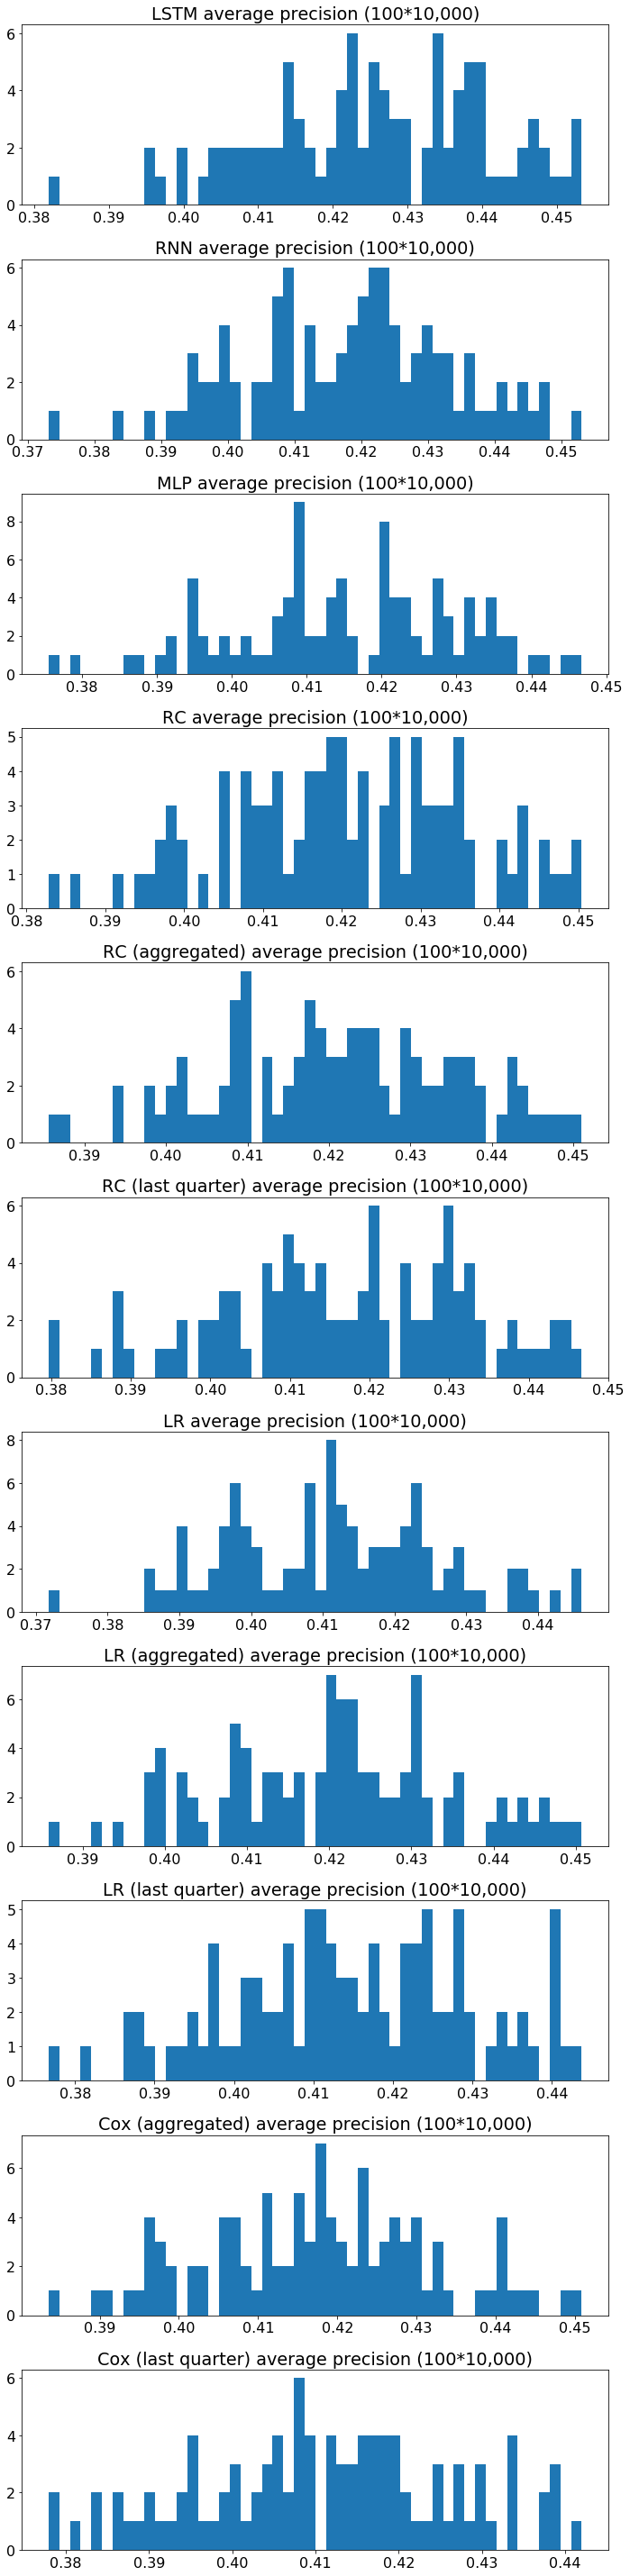

In [87]:
from sklearn.metrics import average_precision_score
from scipy.stats import wilcoxon
from scipy.stats import ttest_ind

n_per_fold = bstrap_v.shape[0]//100
print("Number per fold:", n_per_fold)

ap_scores = np.empty((100, 11))

for i in range(100):
    for j in range(11):
        ap_scores[i, j] = average_precision_score(bstrap_v[(i*n_per_fold):
                                                           ((i+1)*n_per_fold), 0], 
                                                  bstrap_v[(i*n_per_fold):
                                                           ((i+1)*n_per_fold), (j+1)])
print(np.round(ap_scores, decimals=3))
fig, axs = pyplot.subplots(11, 1, figsize=(10, 40))
model_names = {0:"LSTM", 1:"RNN", 2:"MLP", 3:"RC", 
               4:"RC (aggregated)", 5:"RC (last quarter)",
               6:"LR", 7:"LR (aggregated)", 
               8:"LR (last quarter)", 9:"Cox (aggregated)",
               10:"Cox (last quarter)"}
for i in range(11):
    axs[i].hist(ap_scores[:, i], bins=50)
    axs[i].set_title(model_names[i] + " average precision (100*10,000)")
fig.tight_layout()
pyplot.show()

In [88]:
ap_scores_df = pd.DataFrame(ap_scores)
ap_scores_df.columns = ["LSTM", "RNN", "MLP", "RC", 
                        "RC (aggregated)", "RC (last quarter)", 
                        "LR", "LR (aggregated)", "LR (last quarter)", 
                        "Cox (aggregated)", "Cox (last quarter)"]
feather.write_dataframe(ap_scores_df, "/home/whsu014/data/ap_scores_IFC_patched.feathers")

In [89]:
print(ap_scores_df.shape)

(100, 11)
